In [486]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')

## Wczytywanie danych i wstępne rozeznanie

In [487]:
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")
df_val = pd.read_csv("val.csv")

In [488]:
df_test.head()

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,0,13.34,0.94,2.36,17.0,110,2.53,1.30,0.55,0.42,3.17,1.02,1.93,750
1,0,12.00,0.92,2.00,19.0,86,2.42,2.26,0.30,1.43,2.50,1.38,3.12,278
2,0,11.84,0.89,2.58,18.0,94,2.20,2.21,0.22,2.35,3.05,0.79,3.08,520
3,0,12.47,1.52,2.20,19.0,162,2.50,2.27,0.32,3.28,2.60,1.16,2.63,937
4,0,11.81,2.12,2.74,21.5,134,1.60,0.99,0.14,1.56,2.50,0.95,2.26,625


In [489]:
df_val.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,13.86,1.51,2.67,25.0,86,2.95,2.86,0.21,1.87,3.38,1.36,3.16,410
1,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
2,12.82,3.37,2.30,19.5,88,1.48,0.66,0.40,0.97,10.26,0.72,1.75,685
3,12.37,1.07,2.10,18.5,88,3.52,3.75,0.24,1.95,4.50,1.04,2.77,660
4,13.50,1.81,2.61,20.0,96,2.53,2.61,0.28,1.66,3.52,1.12,3.82,845


In [490]:
gmm = mixture.GaussianMixture()

In [491]:
gmm.fit(df_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [492]:
def find_outliers(model, df, name):
  values = model.score_samples(df)
  #score_samples zwraca nam zlogarytmowane prawdopodobieństwa przynależności dla każdego rekordu.
  #Intuicja- rekordy o najmniejszej wartości prawdopodobieństwa powinny być outlierami.
  #Przekształcimy teraz nasze values, by móc je potem zwizualizować. Podnosimy je do kwadratu by zwiększyć różnice między nimi,
  # teraz więc szukamy wartości największych.
  values = [item**2 for item in values]
  values = np.array(values)
  #Zastosujemy też pewien rodzaj skalowania, by móc wydobyć odstajace wartości.
  outs = [(item - min(values))/(max(values)-min(values)) for item in values]
  outs = np.array(outs)
  outs.round(2)
  y = [0] * 17
  y= np.array(y)
  #Testy, jak i wykresy pokazały, że 0.2 jest dobrym punktem odcięcia.
  y[np.where(outs > 0.2)] = 1

  #Zwizualizujmy tez nasze prawdopodobieństwa:
  plt.plot(outs)
  plt.scatter(np.where(outs > 0.2), outs[np.where(outs > 0.2)], c='red')
  plt.hlines(y = 0.2, xmin = 0, xmax = 16, alpha = 0.2)
  plt.title("Propabilities for {} dataframe".format(name))
  plt.show()

  return y

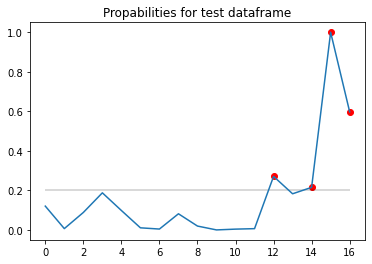

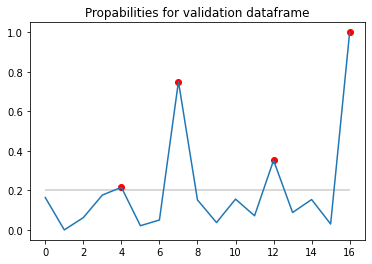

In [493]:
y_test = find_outliers(gmm, df_test.iloc[:,1:], "test")
y_val = find_outliers(gmm, df_val, "validation")

In [494]:
from sklearn.decomposition import PCA

In [495]:
pca = PCA(n_components=2)

In [496]:
test_pca = pca.fit_transform(df_test.iloc[:,1:])

In [497]:
val_pca = pca.fit_transform(df_val)

In [498]:
y = df_test.iloc[:,0]

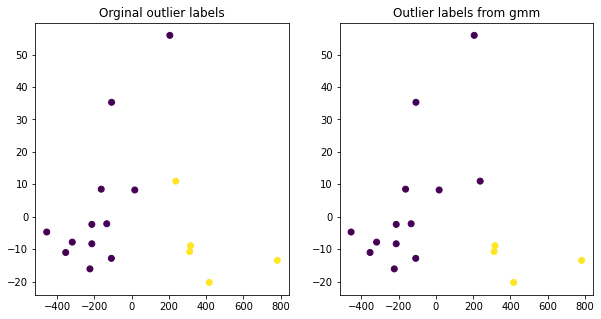

In [499]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.scatter(test_pca[:,0], test_pca[:,1], c = y)
ax1.set_title("Orginal outlier labels")
ax2.scatter(test_pca[:,0], test_pca[:,1], c = y_test)
ax2.set_title("Outlier labels from gmm")
plt.show()

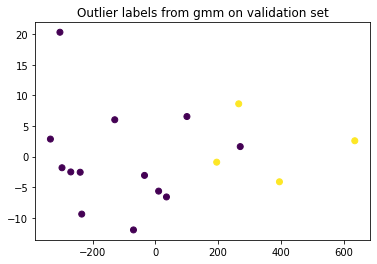

In [500]:
plt.scatter(val_pca[:,0], val_pca[:,1], c = y_val)
plt.title("Outlier labels from gmm on validation set")
plt.show()

In [501]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [502]:
pr = precision_score(y,y_test)
r = recall_score(y,y_test)
f1 = f1_score(y,y_test)

In [503]:
print("SCORES FOR TEST SET")
print("Precision score: {}".format(pr))
print("Recall score: {}".format(r))
print("F1-score: {}".format(f1))

SCORES FOR TEST SET
Precision score: 1.0
Recall score: 0.8
F1-score: 0.888888888888889


Wniosek: wygląda na to, że gmm pozwala na wykrywanie wartości odstających w zbiorach.

Praca została oparta m.in. o [ten artykuł](https://ieeexplore.ieee.org/document/8227312).